## Fall Detection using CNN-LSTM:

---





### Downloading required packages and Libraries

In [1]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

  if event.key is 'enter':



In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

### Getting the dataset:

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls /content/drive/MyDrive/Fall_Detection

dataset.pkl  Fall  features.npy  labels.npy  No_Fall  video_files_paths.txt


In [6]:
import os
import glob

base_path = '/content/drive/MyDrive/Fall_Detection'
class_folders = {0: "Fall", 1: "No_Fall"}
fall_folder = '/content/drive/MyDrive/Fall_Detection/Fall'
no_fall_folder = '/content/drive/MyDrive/Fall_Detection/No_Fall'

### Pre-Processing:

In [7]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 10

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["Fall", "No_Fall"]

In [ ]:
def augment_frame(frame):
    '''
    Apply data augmentation to a single frame.
    Args:
        frame: The input frame (numpy array).
    Returns:
        Augmented frame.
    '''
    if random.random() < 0.5:
        frame = cv2.flip(frame, 1)  # Horizontal flip

    if random.random() < 0.5:
        factor = random.uniform(0.8, 1.2)  # Adjust brightness
        frame = cv2.convertScaleAbs(frame, alpha=factor, beta=0)

    if random.random() < 0.5:
        angle = random.uniform(-10, 10)  # Rotate frame
        height, width = frame.shape[:2]
        matrix = cv2.getRotationMatrix2D((width // 2, height // 2), angle, 1)
        frame = cv2.warpAffine(frame, matrix, (width, height), borderMode=cv2.BORDER_REFLECT)

    return frame

In [8]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            print(f'Error: Could not read frame from {video_path}')
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Apply data augmentation
        #augmented_frame = augment_frame(normalized_frame)

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

#### **<font style="color:rgb(134,19,348)">Create a Function for Dataset Creation</font>**

Now we will create a function **`create_dataset()`** that will iterate through all the classes specified in the **`CLASSES_LIST`** constant and will call the function  **`frame_extraction()`** on every video file of the selected classes and return the frames (**`features`**), class index ( **`labels`**), and video file path (**`video_files_paths`**).

In [9]:
import cv2
import numpy as np
from sklearn.utils import shuffle

def augment_sequence(frames):
    '''
    Apply the same augmentation to all frames in a video sequence.
    Args:
        frames: List or numpy array of video frames (H, W, C).
    Returns:
        Augmented frames as a numpy array.
    '''
    # Randomly decide augmentation parameters
    flip = random.random() < 0.5  # Randomly decide whether to flip horizontally
    brightness_factor = random.uniform(0.9, 1.1)  # Adjust brightness
    angle = random.uniform(-5, 5)  # Small rotation

    augmented_frames = []
    for frame in frames:
        if flip:
            frame = cv2.flip(frame, 1)  # Horizontal flip

        # Brightness adjustment
        frame = cv2.convertScaleAbs(frame, alpha=brightness_factor, beta=0)

        # Rotate frame
        height, width = frame.shape[:2]
        matrix = cv2.getRotationMatrix2D((width // 2, height // 2), angle, 1)
        frame = cv2.warpAffine(frame, matrix, (width, height), borderMode=cv2.BORDER_REFLECT)

        augmented_frames.append(frame)

    return np.array(augmented_frames)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def create_dataset(base_path, class_folders,augment=False):
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = [] # frames of a video
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        #files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        #print('base_path:',base_path)
        #print('class_name:',class_name)
        class_folder_path = os.path.join(base_path, class_name)
        files_list = os.listdir(class_folder_path)

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            #print('Class_Folder:',class_folder_path)
            #print('File_Name:',file_name)
            video_file_path = os.path.join(class_folder_path, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
              if augment:
                frames = augment_sequence(frames)

                # Append the data to their repective lists.
              features.append(frames)
              labels.append(class_index)
              video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Shuffle the dataset to ensure random ordering
    features, labels = shuffle(features, labels, random_state=seed_constant)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [11]:
# Create the dataset.
features, labels, video_files_paths = create_dataset(base_path, class_folders)

Extracting Data of Class: Fall
Extracting Data of Class: No_Fall


In [12]:
print(f"Features shape BEFORE DOWNLOAING: {features.shape}")
print(f"Labels shape BEFORE DOWNLOAING: {labels.shape}")
print(f"Number of video paths BEFORE DOWNLOADING: {len(video_files_paths)}")

#Save features and labels as .npy files
np.save('features.npy', features)
np.save('labels.npy', labels)

#Save video file paths as a text file
with open('video_files_paths.txt', 'w') as f:
  for path in video_files_paths:
    f.write(f"{path}\n")

import pickle

#Save everything into a single pickle file
with open('dataset.pkl', 'wb') as f: pickle.dump({'features': features, 'labels': labels, 'video_files_paths': video_files_paths}, f)

########### AFTER THIS STEP, UPLOAD FILES TO THE FALL_DATASET FOLDER IN GOOGLE DRIVE #############

Features shape BEFORE DOWNLOAING: (1610, 5, 64, 64, 3)
Labels shape BEFORE DOWNLOAING: (1610,)
Number of video paths BEFORE DOWNLOADING: 1610


In [13]:
from google.colab import files
files.download('dataset.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
files.download('features.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
files.download('video_files_paths.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
import numpy as np
import pickle

# Mount Google Drive
#drive.mount('/content/drive')

# Define the file paths (adjust based on your folder structure in Drive)
dataset_folder = '/content/drive/MyDrive/Fall_Detection'

# Load features and labels
features = np.load(f'{dataset_folder}/features_2.npy')
labels = np.load(f'{dataset_folder}/labels_2.npy')

# Load video file paths
with open(f'{dataset_folder}/video_files_paths_2.txt', 'r') as f:
    video_files_paths = [line.strip() for line in f]

# Load everything from the pickle file
with open(f'{dataset_folder}/dataset_2.pkl', 'rb') as f:
    data = pickle.load(f)

features = data['features']
labels = data['labels']
video_files_paths = data['video_files_paths']

print(f"Features shape AFTER UPLOADING: {features.shape}")
print(f"Labels shape AFTER UPLOADING: {labels.shape}")
print(f"Number of video paths AFTER UPLOADING: {len(video_files_paths)}")

Features shape AFTER UPLOADING: (1610, 10, 64, 64, 3)
Labels shape AFTER UPLOADING: (1610,)
Number of video paths AFTER UPLOADING: 1610


In [16]:
features.shape # Use this to divide the test-train splits

(1610, 5, 64, 64, 3)

In [17]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [18]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
#features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
#                                                                            test_size = 0.10, shuffle = True,
#                                                                            random_state = seed_constant)

features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size=0.10, stratify=labels,
                                                                            random_state=seed_constant)


### **<font style="color:rgb(134,19,348)"> Implement the ConvLSTM Approach</font>**

In this step, we will implement the first approach by using a combination of ConvLSTM cells. A ConvLSTM cell is a variant of an LSTM network that contains convolutions operations in the network. it is an LSTM with convolution embedded in the architecture, which makes it capable of identifying spatial features of the data while keeping into account the temporal relation.

<center>
<img src="https://drive.google.com/uc?export=view&id=1KHN_JFWJoJi1xQj_bRdxy2QgevGOH1qP" width= 500px>
</center>


For video classification, this approach effectively captures the spatial relation in the individual frames and the temporal relation across the different frames. As a result of this convolution structure, the ConvLSTM is capable of taking in 3-dimensional input `(width, height, num_of_channels)` whereas a simple LSTM only takes in 1-dimensional input hence an LSTM is incompatible for modeling Spatio-temporal data on its own.

You can read the paper [**Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting**](https://arxiv.org/abs/1506.04214v1) by **Xingjian Shi** (NIPS 2015), to learn more about this architecture.


#### **<font style="color:rgb(134,19,348)">Construct the Model</font>**


To construct the model, we will use Keras [**`ConvLSTM2D`**](https://keras.io/api/layers/recurrent_layers/conv_lstm2d) recurrent layers. The **`ConvLSTM2D`** layer also takes in the number of filters and kernel size required for applying the convolutional operations. The output of the layers is flattened in the end and is fed to the **`Dense`** layer with softmax activation which outputs the probability of each action category.

We will also use **`MaxPooling3D`** layers to reduce the dimensions of the frames and avoid unnecessary computations and **`Dropout`** layers to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting) the model on the data. The architecture is a simple one and has a small number of trainable parameters. This is because we are only dealing with a small subset of the dataset which does not require a large-scale model.

In [53]:
from tensorflow.keras.regularizers import l2

def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

     # First ConvLSTM2D Layer
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.3, return_sequences=True, input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.3)))

    # Second ConvLSTM2D Layer
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.3, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.3)))


    # Third ConvLSTM2D Layer
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.3, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.4)))

    # Fourth ConvLSTM2D Layer
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.4, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    # Final Layers:
    model.add(Flatten())
    model.add(Dense(len(CLASSES_LIST), activation = "softmax", kernel_regularizer=l2(0.01)))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [54]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

  super().__init__(**kwargs)



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d_4 (ConvLSTM2D)           │ (None, 5, 62, 62, 4)        │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 5, 31, 31, 4)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, 5, 31, 31, 4)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)           │ (None, 5, 29, 29, 8)        │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 5, 15, 15, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_16                  │ (None, 5, 15, 15, 8)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_6 (ConvLSTM2D)           │ (None, 5, 13, 13, 14)       │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 5, 7, 7, 14)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_17                  │ (None, 5, 7, 7, 14)         │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)           │ (None, 5, 5, 5, 16)         │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_7 (MaxPooling3D)       │ (None, 5, 3, 3, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 720)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │           1,442 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,442 (134.54 KB)

 Trainable params: 34,442 (134.54 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


##### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**


Now we will use the **`plot_model()`** function, to check the structure of the constructed model, this is helpful while constructing a complex network and making that the network is created correctly.

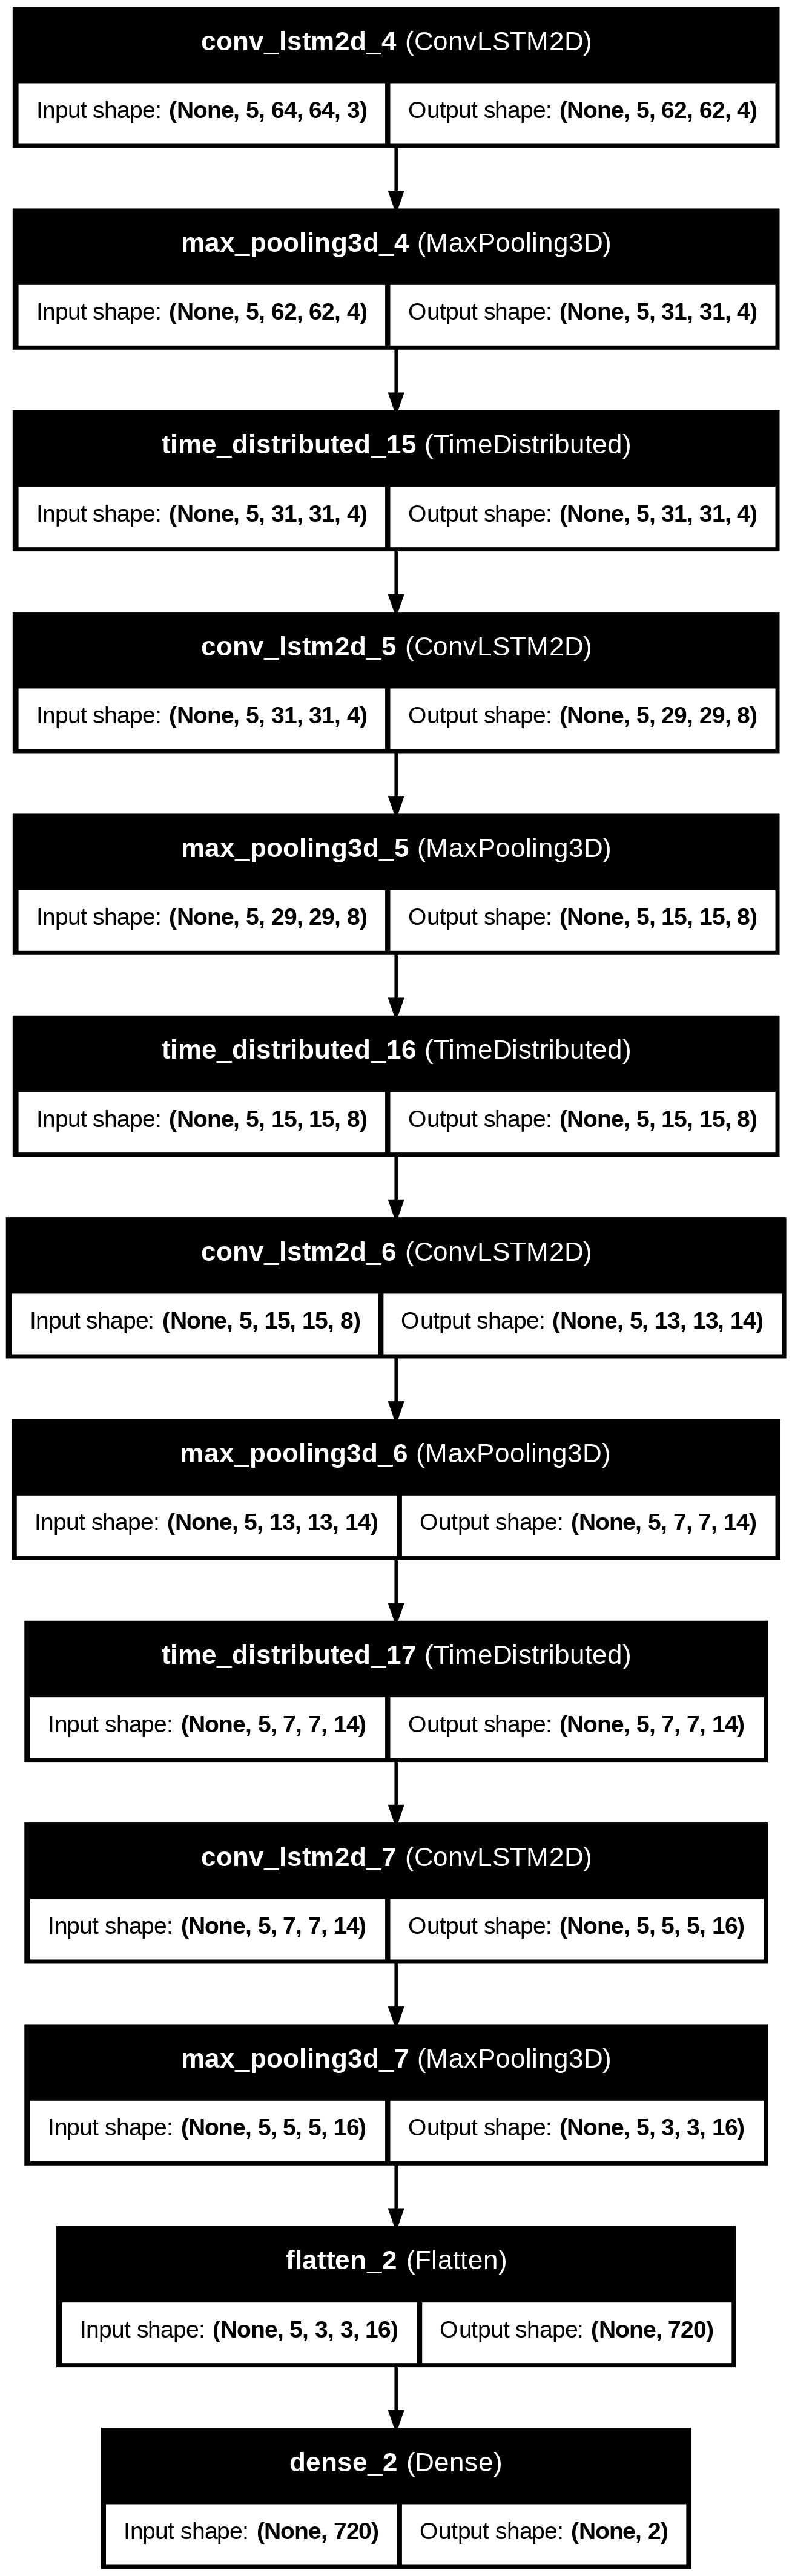

In [55]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

#### **<font style="color:rgb(134,19,348)">Compile & Train the Model</font>**

Next, we will add an early stopping callback to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting) and start the training after compiling the model.

In [56]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [23]:
# Learning rate scheduler to reduce learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

In [93]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer=Adam(learning_rate=0.0010), metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 8,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks=[early_stopping_callback])

Epoch 1/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 65s 226ms/step - accuracy: 0.8912 - loss: 0.3087 - val_accuracy: 0.7241 - val_loss: 0.6097
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.8701 - loss: 0.3349 - val_accuracy: 0.7448 - val_loss: 0.5880
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8845 - loss: 0.3135 - val_accuracy: 0.7138 - val_loss: 0.6204
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8860 - loss: 0.3053 - val_accuracy: 0.7207 - val_loss: 0.5987
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8930 - loss: 0.3055 - val_accuracy: 0.7517 - val_loss: 0.5984
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9140 - loss: 0.2746 - val_accuracy: 0.7379 - val_loss: 0.5888
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9218 - loss: 0.2491 - val_accuracy: 0.7207 - val_loss: 0.6402
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9207 - loss: 0.2502 - val_a

##### **<font style="color:rgb(134,19,348)">Evaluate the Trained Model</font>**

After training, we will evaluate the model on the test set.

In [94]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step - accuracy: 0.7993 - loss: 0.6817


##### **<font style="color:rgb(134,19,348)">Save the Model</font>**

Now we will save the model to avoid training it from scratch every time we need the model.

In [95]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

#### **<font style="color:rgb(134,19,348)">Plot Model’s Loss & Accuracy Curves</font>**


Now we will create a function **`plot_metric()`** to visualize the training and validation metrics. We already have separate metrics from our training and validation steps so now we just have to visualize them.

In [80]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

In [96]:
files.download('/content/convlstm_model___Date_Time_2024_12_11__08_17_14___Loss_0.6197389960289001___Accuracy_0.8012422323226929.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now we will utilize the function **`plot_metric()`** created above, to visualize and understand the metrics.

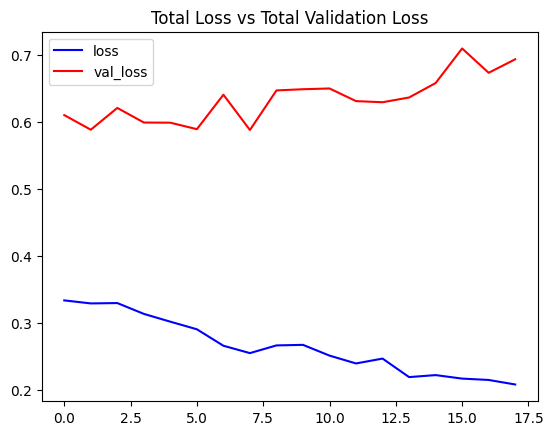

In [97]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

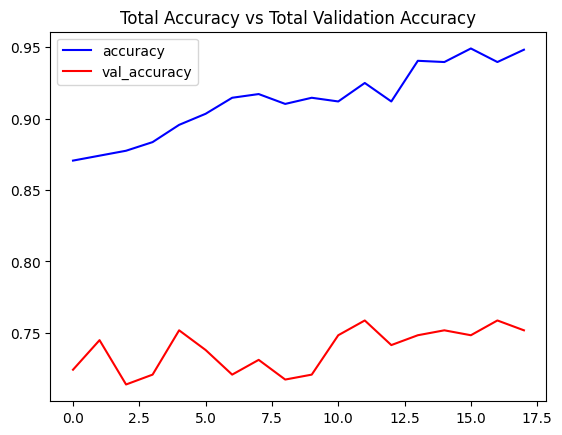

In [98]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

### **<font style="color:rgb(134,19,348)">Implement the LRCN Approach</font>**

In this step, we will implement the LRCN Approach by combining Convolution and LSTM layers in a single model. Another similar approach can be to use a CNN model and LSTM model trained separately. The CNN model can be used to extract spatial features from the frames in the video, and for this purpose, a pre-trained model can be used, that can be fine-tuned for the problem. And the LSTM model can then use the features extracted by CNN, to predict the action being performed in the video.


But here, we will implement another approach known as the Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

<center>
<img src='https://drive.google.com/uc?export=download&id=1I-q5yLsIoNh2chfzT7JYvra17FsXvdme'>
</center>


You can read the paper [Long-term Recurrent Convolutional Networks for Visual Recognition and Description](https://arxiv.org/abs/1411.4389?source=post_page---------------------------) by Jeff Donahue (CVPR 2015), to learn more about this architecture.

We will also use [**`TimeDistributed`**](https://keras.io/api/layers/recurrent_layers/time_distributed/) wrapper layer, which allows applying the same layer to every frame of the video independently. So it makes a layer (around which it is wrapped) capable of taking input of shape `(no_of_frames, width, height, num_of_channels)` if originally the layer's input shape was `(width, height, num_of_channels)` which is very beneficial as it allows to input the whole video into the model in a single shot.

<center>
<img src='https://drive.google.com/uc?export=download&id=1CbauSm5XTY7ypHYBHH7rDSnJ5LO9CUWX' width=400>
</center>

In [66]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [67]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_18                  │ (None, 5, 64, 64, 16)       │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_19                  │ (None, 5, 16, 16, 16)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_20                  │ (None, 5, 16, 16, 16)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_21                  │ (None, 5, 16, 16, 32)       │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_22                  │ (None, 5, 4, 4, 32)         │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_23                  │ (None, 5, 4, 4, 32)         │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_24                  │ (None, 5, 4, 4, 64)         │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_25                  │ (None, 5, 2, 2, 64)         │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_26                  │ (None, 5, 2, 2, 64)         │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_27                  │ (None, 5, 2, 2, 64)         │          36,928 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_28                  │ (None, 5, 1, 1, 64)         │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_29                  │ (None, 5, 64)               │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,994 (285.13 KB)

 Trainable params: 72,994 (285.13 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


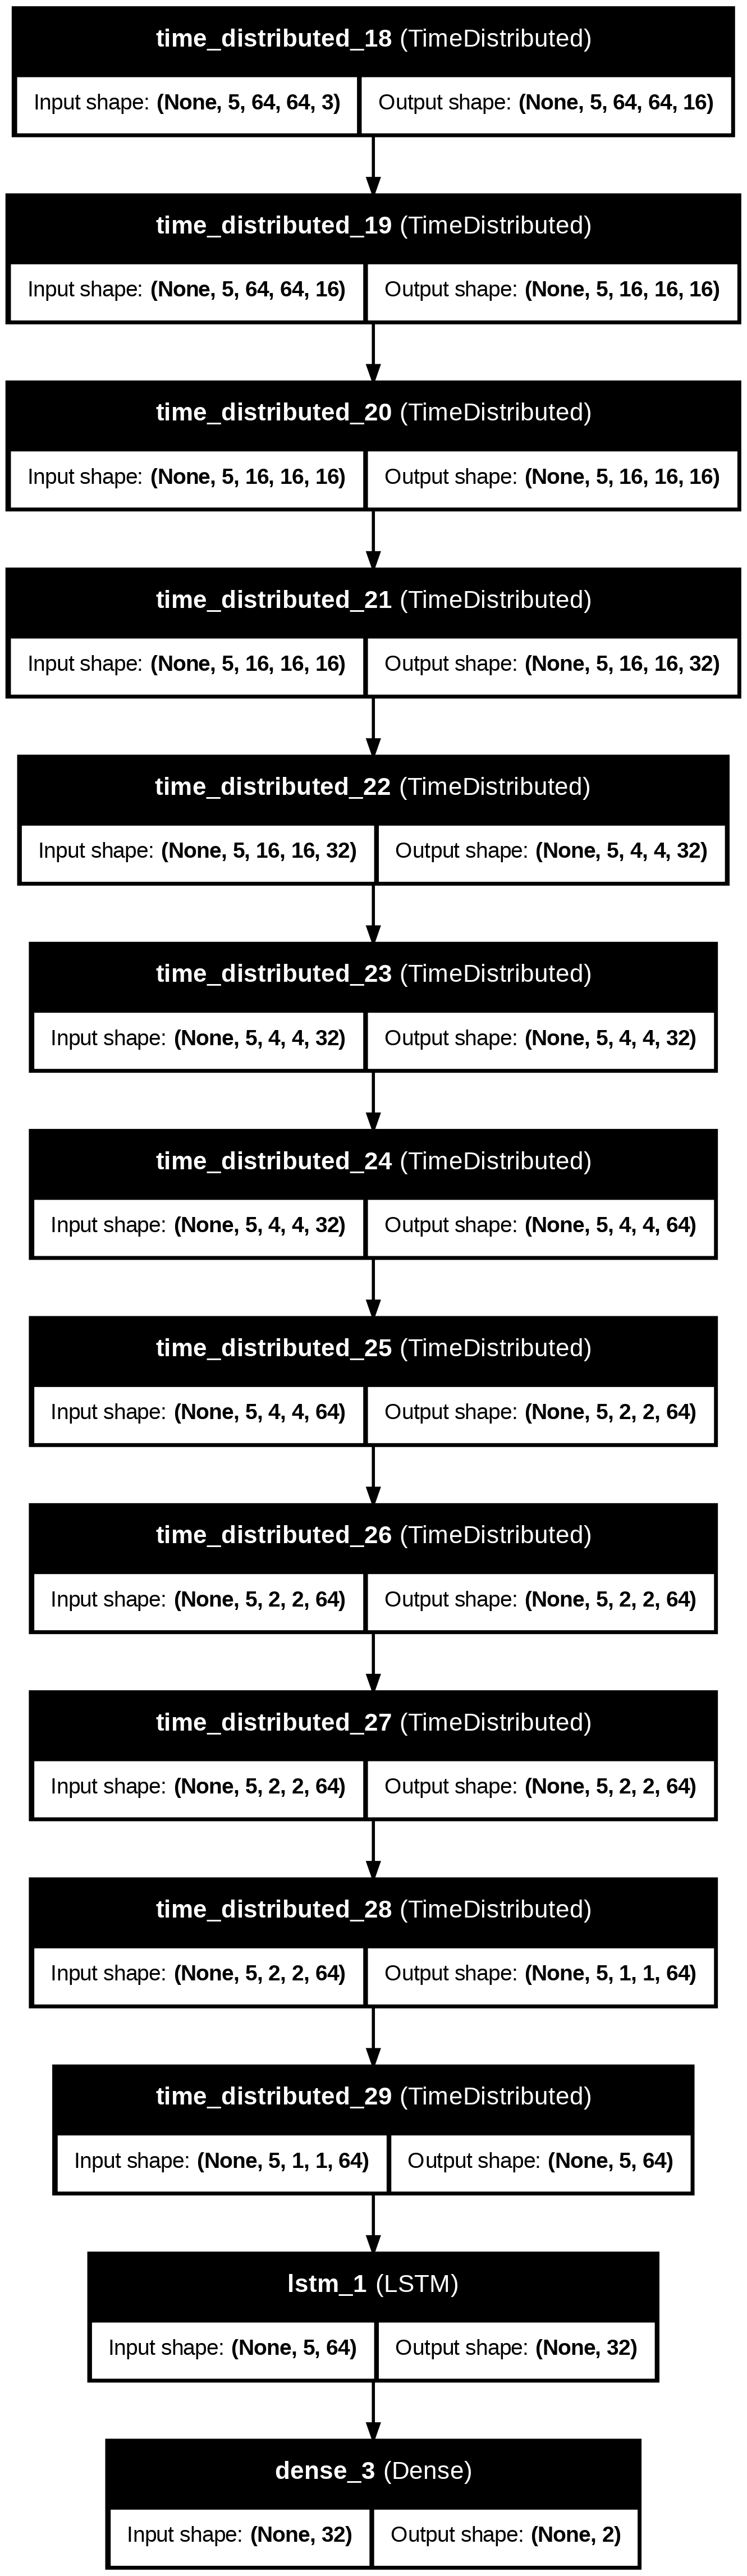

In [68]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [38]:
# Learning rate scheduler to reduce learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

In [103]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2,  callbacks=[early_stopping_callback])

Epoch 1/70
145/145 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.8946 - loss: 0.2687 - val_accuracy: 0.7931 - val_loss: 0.4981
Epoch 2/70
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9010 - loss: 0.2328 - val_accuracy: 0.7828 - val_loss: 0.5102
Epoch 3/70
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9078 - loss: 0.2526 - val_accuracy: 0.7759 - val_loss: 0.4910
Epoch 4/70
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8920 - loss: 0.2493 - val_accuracy: 0.8138 - val_loss: 0.4902
Epoch 5/70
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9143 - loss: 0.2259 - val_accuracy: 0.8103 - val_loss: 0.5013
Epoch 6/70
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9091 - loss: 0.2164 - val_accuracy: 0.8069 - val_loss: 0.4958
Epoch 7/70
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9115 - loss: 0.2049 - val_accuracy: 0.7759 - val_loss: 0.5416
Epoch 8/70
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9399 - loss: 0.1607 - val_accu

In [104]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8219 - loss: 0.4881 


In [105]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

In [108]:
files.download('/content/LRCN_model___Date_Time_2024_12_11__08_26_13___Loss_0.4918324649333954___Accuracy_0.8260869383811951.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

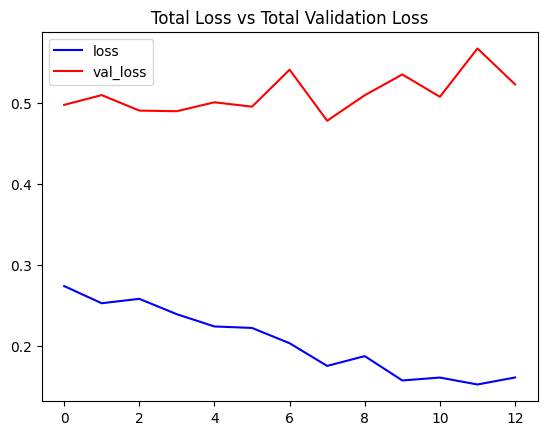

In [106]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

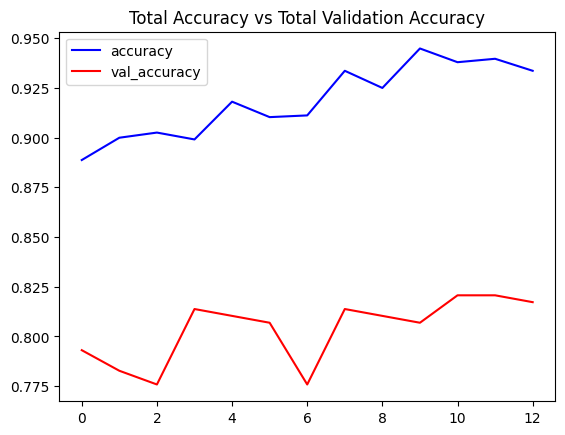

In [107]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

### Prediction:

In [109]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [110]:
# Construct the output video path.
#output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
input_video_file_path = '/content/test_manoj5.mp4'
output_video_file_path = '/content/test_manoj_tested5.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [111]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    # Release the VideoCapture object.
    video_reader.release()

In [112]:
# Download the youtube video.
#video_title = download_youtube_videos('https://youtu.be/fc3w827kwyA', test_videos_directory)

# Construct tihe nput youtube video path
#input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'
input_video_file_path = '/content/test_manoj5.mp4'
output_video_file_path = '/content/test_arun.mp4'
# Perform Single Prediction on the Test Video.
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

# Display the input video.
VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Action Predicted: Fall
Confidence: 0.9172593951225281
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
